In [7]:
pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 7.3 MB/s 
     |████████████████████████████████| 287 kB 59.3 MB/s 


In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from wordcloud import WordCloud

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions

# 1. Exploration du jeu de données

In [9]:
DATASET_FILE = "./dataset.csv"

In [11]:
dataset_df = pd.read_csv(DATASET_FILE)
dataset_df

,text,stars
0,I've only had food from here once and it wasn'...,1
1,I will never return here again. Ever. I was ...,1
2,I wish my experience was great as others. I di...,1
3,Are the rosemary grapefruit scones supposed to...,1
4,Our takeout order was half wrong. Food was mis...,1
...,...,...
24995,I was a loyal fan of Aroy before the ownership...,5
24996,Stopped here for a bite while wandering around...,5
24997,"A quiet place with excellent food, great music...",5
24998,Super delicious food. Awesome vibe. I suffered...,5


## 1.1 Répartition des avis clients en fonction du nombre d'étoiles

In [ ]:
stars_columns = dataset_df.stars
stars_columns

0        1
1        1
2        1
3        1
4        1
        ..
24995    5
24996    5
24997    5
24998    5
24999    5
Name: stars, Length: 25000, dtype: int64

In [ ]:
stars_columns.value_counts()

1    5000
2    5000
3    5000
4    5000
5    5000
Name: stars, dtype: int64

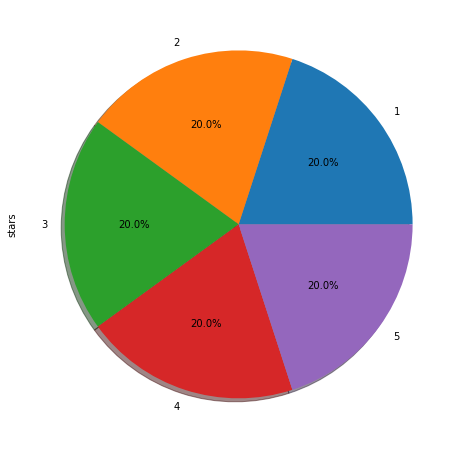

In [ ]:
stars_columns.value_counts().plot(kind="pie", figsize=(10, 8), autopct="%1.1f%%", shadow=True)

## 1.2 Distribution de la longueur (nombre de mots) des avis clients

In [ ]:
dataset_df["length"] = dataset_df["text"].apply(lambda x: len(x.split()))
dataset_df

,text,stars,length
0,I've only had food from here once and it wasn'...,1,68
1,I will never return here again. Ever. I was ...,1,87
2,I wish my experience was great as others. I di...,1,166
3,Are the rosemary grapefruit scones supposed to...,1,81
4,Our takeout order was half wrong. Food was mis...,1,32
...,...,...,...
24995,I was a loyal fan of Aroy before the ownership...,5,75
24996,Stopped here for a bite while wandering around...,5,55
24997,"A quiet place with excellent food, great music...",5,32
24998,Super delicious food. Awesome vibe. I suffered...,5,41


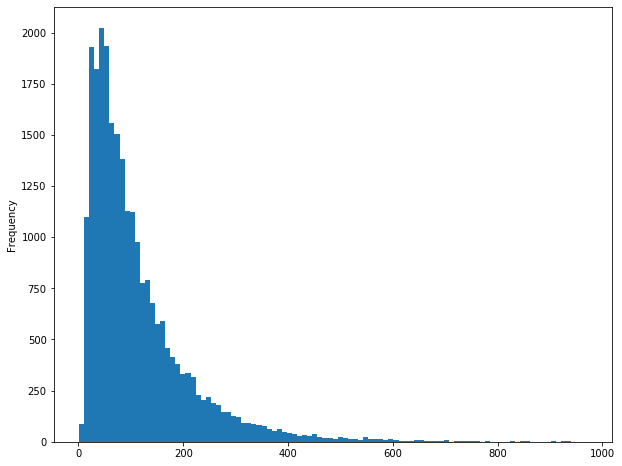

In [ ]:
dataset_df.length.plot(kind="hist", bins=100, figsize=(10, 8))

## 1.3 Distribution de la longueur des avis clients en fonction du nombre d'étoiles des avis

Text(0.5, 1.0, "Répartition des longueurs des avis en fonction du nombre d'étoiles")

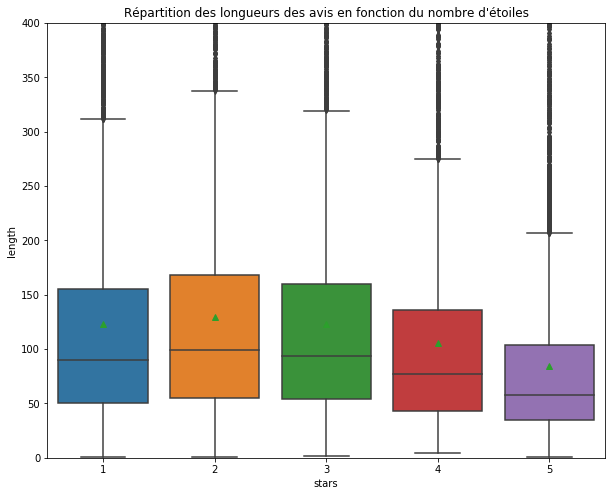

In [ ]:
plt.figure(figsize=(10, 8))

ax = sns.boxplot(x=dataset_df.stars ,
            y=dataset_df.length,
            showmeans=True,
            )
ax.set_ylim(0, 400)

ax.set_title("Répartition des longueurs des avis en fonction du nombre d'étoiles")

# 2. Pré-traitement du jeu de données

In [63]:
import re
keywordSet = {"don't","never", "nothing", "nowhere", "noone", "none", "not",
                  "hasn't","hadn't","can't","couldn't","shouldn't","won't",
                  "wouldn't","don't","doesn't","didn't","isn't","aren't","ain't"}

def negatif_tokens(current_wordset):
  j=0
  while j<len(current_wordset)-1:
    if current_wordset[j] in keywordSet:
      current_wordset[j]= 'not_'+current_wordset[j+1]
      current_wordset.pop(j+1)
    j+=1
  return current_wordset

In [67]:
#stop words
import spacy
import gensim


def remove_stopwords(text_tokens):
	text_without_sw = []
	for word in text_tokens:
		# checking word is stopword or not
		if word not in all_stopwords:
			text_without_sw.append(word)
	 
	return text_without_sw

nltk.download('stopwords')
# list of stopwords from nltk
stopwords_nltk = list(stopwords.words('english'))
sp = spacy.load('en_core_web_sm')
# list of stopwords from spacy
stopwords_spacy = list(sp.Defaults.stop_words)
# list of stopwords from gensim
stopwords_gensim = list(gensim.parsing.preprocessing.STOPWORDS)

# unique stopwords from all stopwords
all_stopwords = []
all_stopwords.extend(stopwords_nltk)
all_stopwords.extend(stopwords_spacy)
all_stopwords.extend(stopwords_gensim)
# all unique stop words
all_stopwords = list(set(all_stopwords))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [78]:
from collections import Counter
def remove_frequent(tokens, number_to_remove):
  counted = Counter(tokens)
  most_occur= counted.most_common(number_to_remove)
  for tupl in most_occur:
    counted.pop(tupl[0])
  return counted.keys()

In [60]:
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tag import StanfordTagger
from nltk.corpus.reader.wordnet import VERB, NOUN, ADJ, ADV
dict_pos_map = {
    # Look for NN in the POS tag because all nouns begin with NN
    'NN': NOUN,
    # Look for VB in the POS tag because all nouns begin with VB
    'VB':VERB,
    # Look for JJ in the POS tag because all nouns begin with JJ
    'JJ' : ADJ,
    # Look for RB in the POS tag because all nouns begin with RB
    'RB':ADV  
}
lm = WordNetLemmatizer()
def lemmatize_with_pos_text(tokens):
  normalized_tokens = []
  for tuples in nltk.pos_tag(tokens):
    temp = tuples[0]
    if tuples[1] == "NNP" or tuples[1] == "NNPS":
      continue
    if tuples[1][:2] in dict_pos_map.keys():
      temp = lm.lemmatize(tuples[0].lower(), pos=dict_pos_map[tuples[1][:2]])
    normalized_tokens.append(temp)
  return normalized_tokens

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [62]:
nltk.download('punkt')
import string
from nltk import word_tokenize, punkt
def tokenize_text(text):
  no_punct_seq_tokens = [token for token in word_tokenize(text) if token not in string.punctuation]
  return no_punct_seq_tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [89]:
def preprocess_text(text):

  #contaction expasion
  expanded_text=contractions.fix(text)

  #tokenization
  tokens= tokenize_text(expanded_text)

  #lemmatization with pos taging and to lowercase
  tokens=lemmatize_with_pos_text(tokens)

  #negatif tokens
  tokens=negatif_tokens(tokens)

  #stopwords removal
  tokens=remove_stopwords(tokens)

  #most frequent words removal
  tokens=remove_frequent(tokens,1)

  return ' '.join(tokens)


In [91]:
dataset_df['text_cleaned']=dataset_df['text'].apply(preprocess_text)

In [94]:
#Classification with logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

y = dataset_df['stars']
X = dataset_df['text_cleaned']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)


clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [96]:
#remove positif words from negatif reviews
import pandas as pd
important_tokens_4 = pd.DataFrame(
    data=clf.coef_[3],
    index=vectorizer.get_feature_names(),
    columns=['coefficient']
).sort_values(by=['coefficient'])

important_tokens_5 = pd.DataFrame(
    data=clf.coef_[4],
    index=vectorizer.get_feature_names(),
    columns=['coefficient']
).sort_values(by=['coefficient'])

mots_positifs = []
important_tokens_4 = important_tokens_4[important_tokens_4['coefficient']>1]
important_tokens_5 = important_tokens_5[important_tokens_5['coefficient']>1]
mots_positifs.append(list(important_tokens_4.index))
mots_positifs.append(list(important_tokens_5.index))

df_temp = dataset_df[dataset_df['stars'].isin([1, 2])]
for i in range(0,len(df_temp)):
  text = dataset_df.loc[i,'text_cleaned']
  text = text.split()
  for j in text:
    if j in mots_positifs: text.remove(j)
  dataset_df.loc[i,'text_cleaned'] = ' '.join(text)

In [97]:
dataset_df.to_csv("output.csv")